In [1]:
import json
import pandas as pd
import numpy as np
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [2]:
df = pd.read_csv('fake_job_postings.csv.zip')
print(df.shape)
df.head(2)

(17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [3]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [4]:
df.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

### Target Column

In [5]:
df['fraudulent'].nunique()

2

In [6]:
df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [7]:
cols = df.columns
for col in cols:
    col_text = ' '.join(df[col].astype(str)).split()
    print(col, len(set(col_text)))

job_id 17880
title 7831
location 2715
department 1213
salary_range 875
company_profile 28576
description 151904
requirements 108828
benefits 31993
telecommuting 2
has_company_logo 2
has_questions 2
employment_type 6
required_experience 10
required_education 21
industry 192
function 47
fraudulent 2


### Text Columns to create features


In [8]:
text_cols = ['description', 'requirements', 'company_profile', 'benefits']
for col in text_cols:
    df[col] = df[col].astype(str)

In [9]:
X = df[text_cols] #   .values.astype('U')
y = df['fraudulent']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

### Create TF-IDF based features using the text columns

In [11]:
df_train_feat = pd.DataFrame()
df_test_feat = pd.DataFrame()

for col in text_cols:
    tfidf = TfidfVectorizer(max_features=1000, norm='l2', stop_words = 'english')
    tfidf.fit(X_train[col])
    
    df_train_feat_tmp = tfidf.transform(X_train[col])
    df_train_feat_tmp = pd.DataFrame(df_train_feat_tmp.toarray())
    df_train_feat = pd.concat([df_train_feat, df_train_feat_tmp], axis=1)

    df_test_feat_tmp = tfidf.transform(X_test[col])
    df_test_feat_tmp = pd.DataFrame(df_test_feat_tmp.toarray())
    df_test_feat = pd.concat([df_test_feat, df_test_feat_tmp], axis=1)


print(df_train_feat.shape)
print(df_test_feat.shape)

(14304, 4000)
(3576, 4000)


### Train a Multinomial Naive Bayes Classifier


In [12]:
clf = MultinomialNB()
clf.fit(df_train_feat, y_train)

MultinomialNB()

In [13]:
y_train_pred = clf.predict(df_train_feat)
y_test_pred = clf.predict(df_test_feat)

#### Predicted class probabilities from test data for 5 job advertisements

In [14]:
clf.predict_proba(df_test_feat[:5])

array([[9.93290350e-01, 6.70964973e-03],
       [7.28300303e-01, 2.71699697e-01],
       [9.97736312e-01, 2.26368827e-03],
       [9.99926426e-01, 7.35735994e-05],
       [9.99997663e-01, 2.33667982e-06]])

### Model performance on train data

In [15]:
print("overall occuracy")
print(accuracy_score(y_train, y_train_pred))

overall occuracy
0.9637863534675615


In [16]:
print("ROC AUC score")
print(roc_auc_score(y_train, clf.predict_proba(df_train_feat)[:, 1]))

ROC AUC score
0.9784036402947577


In [17]:
print("classification report")
print(classification_report(y_train, y_train_pred))

classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     13611
           1       0.60      0.75      0.67       693

    accuracy                           0.96     14304
   macro avg       0.79      0.86      0.82     14304
weighted avg       0.97      0.96      0.97     14304



In [18]:
print("confusion matrix")
cm = confusion_matrix(y_train, y_train_pred)
print(cm)

confusion matrix
[[13264   347]
 [  171   522]]


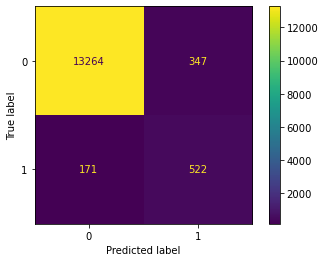

In [19]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

### Model performance on test data

In [20]:
print("overall occuracy")
print(accuracy_score(y_test, y_test_pred))

overall occuracy
0.9566554809843401


In [21]:
print("ROC AUC score")
print(roc_auc_score(y_test, clf.predict_proba(df_test_feat)[:, 1]))

ROC AUC score
0.9692705688112664


In [22]:
print("classification report")
print(classification_report(y_test, y_test_pred))

classification report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3403
           1       0.54      0.71      0.61       173

    accuracy                           0.96      3576
   macro avg       0.76      0.84      0.80      3576
weighted avg       0.96      0.96      0.96      3576



In [23]:
print("confusion matrix")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

confusion matrix
[[3298  105]
 [  50  123]]


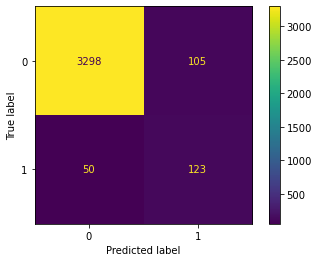

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)